### Анализ эффективности A/B-теста двух вариантов посадочной страницы.


#### 1. Постановка задачи

Турагентство тестирует два варианта посадочной страницы официального сайта (контроль — A, тест — B).

Цель — выбрать вариант, который:

- даёт лучше конверсию в покупку тура;

- обеспечивает более высокий ежедневный средний чек.

Для этого проведён A/B-тест, в котором фиксировались визиты пользователей, факт покупки и стоимость тура.

В рамках проекта:

1. Проверяем корректность проведения эксперимента;

2. Анализируем ключевые метрики по группам;

3. Исследуем динамику и стабилизацию метрик во времени;

4. Проводим статистическую проверку гипотез и формируем бизнес-вывод.

#### Продукт и тарифная сетка.

Компания продаёт туры по фиксированным ценам:

- Таиланд — 100 000 ₽

- Турция — 60 000 ₽

- Мальдивы — 200 000 ₽

- Санкт-Петербург — 10 000 ₽

- Камчатка — 150 000 ₽

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, t, ttest_ind,shapiro, mannwhitneyu, f_oneway
from statsmodels.stats.proportion import proportions_ztest

In [3]:
data = pd.read_csv('/Users/ulabakulina/Desktop/piton/DS_PROD-4. A:B-тестирование/ab_data_tourist.csv')
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


#### 2. Описание данных и первичный осмотр

Данные загружаются из файла `ab_data_tourist.csv`. В таблице представлены поля:

- **user_id** — идентификатор пользователя;
- **date** — дата посещения сайта;
- **group** — экспериментальная группа (`A` или `B`);
- **purchase** — факт покупки тура (1 — покупка была, 0 — покупки не было);
- **price** — стоимость купленного тура; при отсутствии покупки значение равно 0.

Проверяем структуру датафрейма и приводим столбец `date` к формату `datetime`.


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


Столбец date имеет тип данных object, соответственно его нужно привести к типу данных datetime.


In [94]:
data['date']=pd.to_datetime(data['date'],format='%Y-%m-%d')

#### 3. Проверка корректности эксперимента и предобработка

#### 3.1. Период проведения A/B-теста

Смотрим диапазон дат в каждой группе и убеждаемся, что тест проходил в один и тот же период.


In [95]:
data_2=data.groupby('group')['date'].agg(['min','max']).reset_index()
data_2

,group,min,max
0,A,2021-01-02,2021-01-24
1,B,2021-01-02,2021-01-24


In [96]:
data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   group   2 non-null      object        
 1   min     2 non-null      datetime64[ns]
 2   max     2 non-null      datetime64[ns]
dtypes: datetime64[ns](2), object(1)
memory usage: 180.0+ bytes


In [97]:
data_2['max'].max()-data_2['min'].min()

Timedelta('22 days 00:00:00')

В обоих вариантах страницы тест проводился с `2021-01-02` по `2021-01-24`.  
Длительность эксперимента — **22 дня**, период совпадает, дополнительного усечения не требуется.


#### 3.2. Исключение пользователей, попавших в обе группы

Проверяем чистоту разбиения: ищем пользователей, которые оказались одновременно в группах A и B, и исключаем их из анализа.


In [16]:
data_A=set(data[data['group']=='A']['user_id'].unique())
data_B=set(data[data['group']=='B']['user_id'].unique())
print(len(data_A),len(data_B))

146195 146284


In [18]:
user_int=data_A.intersection(data_B)

In [19]:
len(user_int)

1895

In [23]:
update_data=data[~data['user_id'].isin(user_int)]
update_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 290688 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   user_id   290688 non-null  int64         
 1   date      290688 non-null  datetime64[ns]
 2   group     290688 non-null  object        
 3   purchase  290688 non-null  int64         
 4   price     290688 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 13.3+ MB


В пересечении оказалось **1895 пользователей**, которые видели оба варианта посадочной страницы.  
Чтобы не искажать результаты, эти пользователи исключены из обеих групп.  
Итоговый размер выборки — **290 688** наблюдений, пропусков в ключевых полях нет.


#### 4. Сравнение групп: базовые метрики

#### 4.1. Визиты, покупки и выручка

Рассчитываем для каждой группы:
- количество визитов,
- количество покупок,
- суммарную выручку.


In [37]:
data_3=update_data.groupby('group').agg({'user_id': 'count', 'purchase': 'sum', 'price': 'sum'}).reset_index().rename(columns={'user_id': 'count_viz', 'purchase':'count_pur', 'price': 'sum_price' })

In [ ]:
#data_3['sum_price']=data_3['sum_price']/1000000

In [32]:
data_3.head()

,group,count_viz,count_pur,sum_price
0,A,145307,17487,1417.78
1,B,145381,17290,1533.01


Количество визитов и покупок в группах A и B сопоставимо, эксперимент можно считать сбалансированным по трафику.
Теперь считаем конверсию и средний чек.


In [38]:
data_3['conversion']=round(data_3['count_pur']/data_3['count_viz']*100,2)

In [41]:
data_3['mean_chek']=round(data_3['sum_price']/data_3['count_pur'],2)

In [42]:
data_3

,group,count_viz,count_pur,sum_price,conversion,mean_chek
0,A,145307,17487,1417780000,12.03,81076.23
1,B,145381,17290,1533010000,11.89,88664.55


#### 4.2. Конверсия и средний чек

- Конверсия:
  - A — **12.03 %**
  - B — **11.89 %**

- Средний чек:
  - A — **≈ 81 100 ₽**
  - B — **≈ 88 700 ₽**

Группа **A** показывает немного более высокую конверсию,  
а группа **B** — заметно более высокий средний чек.


#### 4.3. Распределение покупок по видам туров

Сравниваем варианты A/B по покупательской способности каждого из туров.  
Строим сводную таблицу количества покупок по комбинации **группа × цена тура**.


In [46]:
pivot=update_data.pivot_table(values='purchase',index='price',columns='group',aggfunc='count')
pivot

group,A,B
price,,
0,127820,128091
10000,5182,5201
60000,5271,1730
100000,1832,5227
150000,3478,3438
200000,1724,1694


<Axes: xlabel='group', ylabel='price'>

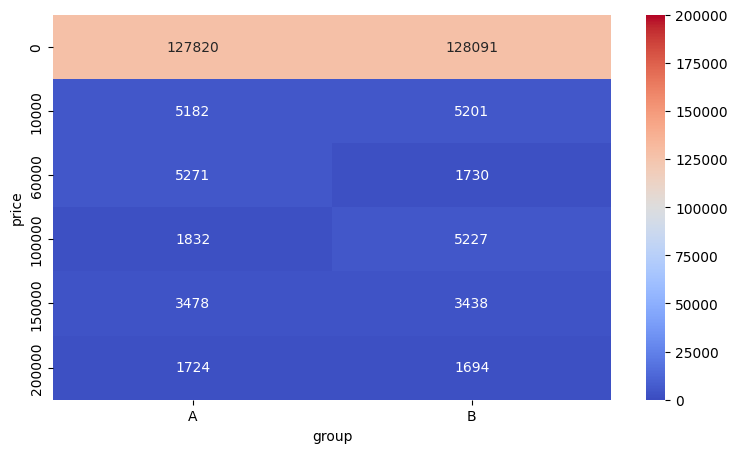

In [51]:
fig=plt.subplots(figsize=(9,5))
sns.heatmap(pivot,annot=True, vmin=0,vmax=200000,center=100000,fmt='1g',cmap='coolwarm')

Покупательская способность:

- для туров стоимостью **60 000, 150 000 и 200 000 ₽** выше в группе **A**;
- для туров стоимостью **10 000 и 100 000 ₽** выше в группе **B**.

Вариант B чаще приводит к покупке самого дешёвого тура и тура за 100 000 ₽,  
при этом средний чек по группе остаётся выше, чем в A.


#### 5. Динамика и стабилизация метрик

#### 5.1. Ежедневные показатели

Агрегируем данные по комбинации **дата × группа** и считаем:
- ежедневное количество визитов,
- количество покупок,
- сумму покупок,
- ежедневную конверсию,
- ежедневный средний чек.


In [53]:
update_data_3=update_data.groupby(['date','group']).agg({'user_id':'count', 'purchase': 'sum', 'price': 'sum'}).reset_index()

In [56]:
update_data_3['conversion']=round(update_data_3['purchase']/update_data_3['user_id']*100,2)

In [57]:
update_data_3['mean_chek']=round(update_data_3['price']/update_data_3['purchase']*100,2)

In [58]:
update_data_3.head()

,date,group,user_id,purchase,price,conversion,mean_chek
0,2021-01-02,A,2854,359,29410000,12.58,8192200.56
1,2021-01-02,B,2861,345,29660000,12.06,8597101.45
2,2021-01-03,A,6596,748,62000000,11.34,8288770.05
3,2021-01-03,B,6619,754,65960000,11.39,8748010.61
4,2021-01-04,A,6566,799,64250000,12.17,8041301.63


Получили ежедневные значения конверсии и среднего чека для обеих групп.  
Далее рассчитываем кумулятивные показатели.


In [60]:
update_data_3['cum_user_count']=update_data_3.groupby(['group'])['user_id'].cumsum()

In [61]:
update_data_3['cum_pur']=update_data_3.groupby(['group'])['purchase'].cumsum()

In [62]:
update_data_3['cum_price']=update_data_3.groupby(['group'])['price'].cumsum()

In [63]:
update_data_3['cum_convercion']=round(update_data_3['cum_pur']/update_data_3['cum_user_count']*100,2)

In [64]:
update_data_3['cum_chek']=round(update_data_3['cum_price']/update_data_3['cum_pur']*100,2)

In [65]:
update_data_3.head()

,date,group,user_id,purchase,price,conversion,mean_chek,cum_user_count,cum_pur,cum_price,cum_convercion,cum_chek
0,2021-01-02,A,2854,359,29410000,12.58,8192200.56,2854,359,29410000,12.58,8192200.56
1,2021-01-02,B,2861,345,29660000,12.06,8597101.45,2861,345,29660000,12.06,8597101.45
2,2021-01-03,A,6596,748,62000000,11.34,8288770.05,9450,1107,91410000,11.71,8257452.57
3,2021-01-03,B,6619,754,65960000,11.39,8748010.61,9480,1099,95620000,11.59,8700636.94
4,2021-01-04,A,6566,799,64250000,12.17,8041301.63,16016,1906,155660000,11.90,8166841.55


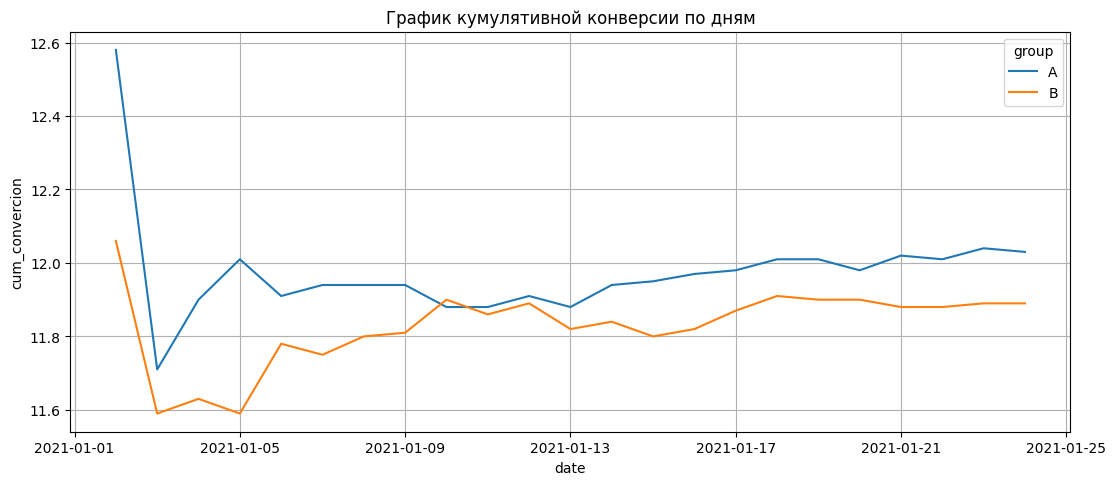

In [66]:
fig=plt.figure(figsize=(10,4))
ax=fig.add_axes([1,1,1,1])
sns.lineplot(x='date', y= 'cum_convercion',data=update_data_3,hue='group',ax=ax)
ax.set_title('График кумулятивной конверсии по дням')
ax.grid(True);

Кумулятивные метрики стабилизируются к концу периода теста.  
После стабилизации кумулятивная конверсия в группе **A** немного выше, чем в **B**.  
Резких скачков в конце периода нет — A/B-тест можно считать **завершённым**,  
а результаты — устойчивыми.


#### 6. Статистический анализ результатов

#### 6.1. Сравнение конверсии

Проверяем гипотезы:
- **H₀:** конверсия в группах A и B одинакова;
- **H₁:** конверсия в группе A выше, чем в группе B.

Используем z-тест для пропорций.


In [70]:
update_data_4=update_data.groupby('group').agg({'user_id':'count', 'purchase': 'sum'}).reset_index()
update_data_4.head()

,group,user_id,purchase
0,A,145307,17487
1,B,145381,17290


In [71]:
H0='Конверсия в группах A и B равны'
H1='Конверсия в группе A выше, чем конверсия в группе B'
alpha=0.05
_,p_value=proportions_ztest(count=update_data_4['purchase'],nobs=update_data_4['user_id'],alternative='larger')
print(p_value)
if p_value<alpha: 
    print(H1)
else: print(H0)   



0.11970374924914917
Конверсия в группах A и B равны


 
Результаты проведенного теста показали, что статистически значимой разницы в конверсии между вариантами **A** и **B** не обнаружено.


#### 6.2. Доверительные интервалы для конверсии

Строим 95%-е доверительные интервалы для конверсии в каждой группе и для разницы конверсий.


In [91]:
a_data=update_data[update_data['group']=='A']
b_data=update_data[update_data['group']=='B']
def proportion_conf_interval(x_p, n, gamma=0.95): 
    alpha=1-gamma
    z_crit=-norm.ppf(alpha/2)
    eps=z_crit*(x_p*(1-x_p)/n)**0.5
    lower_bound=x_p-eps
    upper_bound=x_p+eps
    return round(lower_bound*100,2),round(upper_bound*100,2)

    

In [92]:
conf_a=proportion_conf_interval(x_p=a_data['purchase'].mean(),n=a_data['user_id'].count())
conf_b=proportion_conf_interval(x_p=b_data['purchase'].mean(),n=b_data['user_id'].count())

In [93]:
print('Доверительный интервал для конверсии группы А', conf_a)
print('Доверительный интервал для конверсии группы B', conf_b)

Доверительный интервал для конверсии группы А (11.87, 12.2)
Доверительный интервал для конверсии группы B (11.73, 12.06)


In [81]:
def diff_proportion_conf_interval(x_p, n, gamma=0.95): 
    alpha=1-gamma
    diff=x_p[1]-x_p[0]
    z_crit=-norm.ppf(alpha/2)
    eps=z_crit*(x_p[0]*(1-x_p[0])/n[0]+x_p[1]*(1-x_p[1])/n[1])**0.5
    lower_bound=diff-eps
    upper_bound=diff+eps
    return round(lower_bound*100,2),round(upper_bound*100,2)

In [82]:
n=[a_data['user_id'].count(),b_data['user_id'].count()]
x_p=[a_data['purchase'].mean(),b_data['purchase'].mean()]
diff_proportion_conf_interval(x_p,n)

(-0.38, 0.09)

95%-е доверительные интервалы:

- конверсия A: **[11.87 %; 12.20 %]**
- конверсия B: **[11.73 %; 12.06 %]**
- разница (B − A): **[-0.38 п.п.; 0.09 п.п.]**

Интервал для разницы включает ноль — это подтверждает отсутствие значимого эффекта по конверсии.


#### 6.3. Анализ ежедневного среднего чека

Сначала проверяем нормальность распределения ежедневного среднего чека в каждой группе с помощью теста Шапиро–Уилка.


Будем проверять гипотезы о нормальности распределения ежедневного среднего чека в каждой из групп. 

- H0='Распределения в обеих группах нормальные'
- H1='Распределения в одной или обеих группах отличны от нормального'
- alpha=0.05

In [83]:
H0='Распределения в обеих группах нормальные'
H1='Распределения в одной или обеих группах отличны от нормального'
alpha=0.05
shapiro_a=shapiro(update_data_3[update_data_3['group']=='A']['mean_chek'])
shapiro_b=shapiro(update_data_3[update_data_3['group']=='B']['mean_chek'])

In [84]:
print('p-value группы A',shapiro_a)
print('p-value группы B',shapiro_b)

p-value группы A ShapiroResult(statistic=0.9469830866278297, pvalue=0.2530740450127667)
p-value группы B ShapiroResult(statistic=0.9269076143155807, pvalue=0.09378218963293125)


In [86]:
if shapiro_a.pvalue<alpha or shapiro_b.pvalue<alpha:
    print(H1)
else: print(H0)    

Распределения в обеих группах нормальные


p-value для обеих групп больше 0.05 — нет оснований отвергать H₀.  
Распределения ежедневного среднего чека можно считать нормальными.


#### 6.4. Сравнение среднего чека (t-test)

Проверяем гипотезы:
- **H₀:** средний чек в группах A и B одинаков;
- **H₁:** средний чек в группе A меньше, чем в группе B.

Используем t-критерий для независимых выборок.


In [88]:
H0='Средний чек в группах одинаков'
H1='Средний чек в группе A меньше, чем в группе B'
alpha = 0.05
results=ttest_ind(a=update_data_3[update_data_3['group']=='A']['mean_chek'], b=update_data_3[update_data_3['group']=='B']['mean_chek'],alternative='less')
print(results.pvalue)
if results.pvalue<alpha:
    print(H1)
else: print(H0)    


1.1261794583417187e-12
Средний чек в группе A меньше, чем в группе B


p-value ≈ 1.1e-12 < 0.05 — отвергаем H₀.  
Ежедневный средний чек в группе **A** статистически значимо ниже, чем в группе **B**.


#### 6.5. Доверительные интервалы для среднего чека


In [89]:
update_data_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46 entries, 0 to 45
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            46 non-null     datetime64[ns]
 1   group           46 non-null     object        
 2   user_id         46 non-null     int64         
 3   purchase        46 non-null     int64         
 4   price           46 non-null     int64         
 5   conversion      46 non-null     float64       
 6   mean_chek       46 non-null     float64       
 7   cum_user_count  46 non-null     int64         
 8   cum_pur         46 non-null     int64         
 9   cum_price       46 non-null     int64         
 10  cum_convercion  46 non-null     float64       
 11  cum_chek        46 non-null     float64       
dtypes: datetime64[ns](1), float64(4), int64(6), object(1)
memory usage: 4.4+ KB


Строим 95% доверительный интервал для групп. 

In [90]:
a=update_data_3[update_data_3['group']=='A']['mean_chek']
b=update_data_3[update_data_3['group']=='B']['mean_chek']
n=23
k=n-1
x_mean_a=a.mean()
x_mean_b=b.mean()
x_std_a=a.std()
x_std_b=b.std()
gamma=0.95
alpha=1-gamma 
t_crit=-t.ppf(alpha/2,k)
eps_a=t_crit*x_std_a/(n**0.5)
eps_b=t_crit*x_std_b/(n**0.5)
lower_bound_a=x_mean_a-eps_a
upper_bound_a=x_mean_a+eps_a
lower_bound_b=x_mean_b-eps_b
upper_bound_b=x_mean_b+eps_b
print('Доверительный интервал для выборки A',round(lower_bound_a,2),round(upper_bound_a,2))
print('Доверительный интервал для выборки B',round(lower_bound_b,2),round(upper_bound_b,2))

Доверительный интервал для выборки A 7963035.14 8230821.88
Доверительный интервал для выборки B 8762582.58 8952560.52


95%-е доверительные интервалы ежедневного среднего чека:

- A: **[7.96 млн; 8.23 млн]** (в рублёвом выражении — ≈ 83 тыс. ₽ на покупку);
- B: **[8.76 млн; 8.95 млн]** (≈ 89 тыс. ₽ на покупку).

Интервалы **не пересекаются**, что подтверждает устойчивое преимущество варианта B по среднему чеку.


#### 7. Итоговые выводы для бизнеса

1. **Конверсия**
   - Статистически значимой разницы в конверсии между вариантами **A** и **B** нет.
   - Кумулятивная конверсия группы A немного выше, но эффект находится в пределах статистического шума.

2. **Средний чек**
   - Ежедневный средний чек в группе **B** значимо выше, чем в группе A.
   - Доверительные интервалы не пересекаются, что говорит о стабильном преимуществе варианта B по выручке с одной покупки.

3. **Структура спроса**
   - В группе A чаще покупают туры средней и высокой ценовой категории (60 000, 150 000, 200 000 ₽).
   - В группе B — самый дешёвый тур и тур за 100 000 ₽, при этом общий средний чек всё равно выше.

4. **Рекомендация**
   - Так как конверсия **не отличается статистически**, а **средний чек в группе B выше**,  
     более выгодным для бизнеса является **вариант посадочной страницы B**.  
     Его можно рекомендовать к внедрению как основной.
